In [1]:
# Extensions
%load_ext autoreload
%autoreload 2

In [2]:
# Imports
from glove import *
from utils import *

from core.search.query_paper_mag import paper_mag_multiquery
from core.search.query_info      import paper_info_mag_check_multiquery
from core.utils.entity_type      import Entity_type
from torch.utils.data            import DataLoader
import torch.optim as optim

In [3]:
# Get paper information

# Conf id
conf_id = 1127352206 #PLDI

# Generate papers for the conference
papers = paper_mag_multiquery(Entity_type.CONF, [conf_id])

print("Papers for conference:", len(papers))

# Import paper information here!
paper_informations = paper_info_mag_check_multiquery(papers)

return statue: 403
{'Ocp-Apim-Subscription-Key': '004967a3daac4bf683e16ca2a459de07'}
ERROR: problem with the request.
b'\n{ "error": { "code": "QuotaExceeded", "message": "Out of call volume quota. Quota will be replenished later." } }\n\t\t        \t\t\t\t  '
return statue: 403
{'Ocp-Apim-Subscription-Key': 'ce7734c51f504dcaa1dd89cb88fa153d'}
ERROR: problem with the request.
b'\n{ "error": { "code": "QuotaExceeded", "message": "Out of call volume quota. Quota will be replenished later." } }\n\t\t        \t\t\t\t  '
return statue: 403
{'Ocp-Apim-Subscription-Key': '9c0c0c5e7758484b9ed8092034eac796'}
ERROR: problem with the request.
b'\n{ "error": { "code": "QuotaExceeded", "message": "Out of call volume quota. Quota will be replenished later." } }\n\t\t        \t\t\t\t  '
return statue: 403
{'Ocp-Apim-Subscription-Key': 'aeea5a7bb8fd4d62af6c9c08b26521dc'}
ERROR: problem with the request.
b'\n{ "error": { "code": "QuotaExceeded", "message": "Out of call volume quota. Quota will be reple

In [4]:
# Preprocess
preprocess = TitlePreprocess(paper_informations)
pair_data = preprocess.gen_pairs()
cooc = preprocess.gen_cooc()

In [5]:
# Get context corpus
corpus = TitleWordCorpus(pair_data)

In [6]:
embedding_size = len(preprocess.word2idx)
embedding_dim  = 128

model = GloVe(embedding_size, embedding_dim, cooc, x_max=50)

In [18]:
from tqdm import tqdm

BATCH_SIZE = 64
ITERATIONS = 10
LEARN_RATE = 1

In [19]:
# TODO: Need to make a validation set
training_dataloader = DataLoader(corpus, batch_size=BATCH_SIZE, shuffle=True)

In [20]:
num_batches = int(ITERATIONS)
progress_bar = tqdm(range(1, num_batches + 1))

  0%|          | 0/10 [00:00<?, ?it/s]

In [21]:
optimizer = optim.Adagrad(model.parameters(), lr=LEARN_RATE)
loss_history = list()

for epoch in progress_bar:
    for word_idx, context_idx in training_dataloader:
        optimizer.zero_grad()
        loss = model.forward(word_idx, context_idx)
        loss.backward()
        optimizer.step()
        
        loss_history.append(loss.detach().numpy().item())
    progress_bar.set_description("Loss: %0.8f, lr: %0.6f" % (loss.data.item(), optimizer.param_groups[0]['lr']))

Loss: 319.52804565, lr: 1.000000: 100%|██████████| 10/10 [02:10<00:00, 13.09s/it]


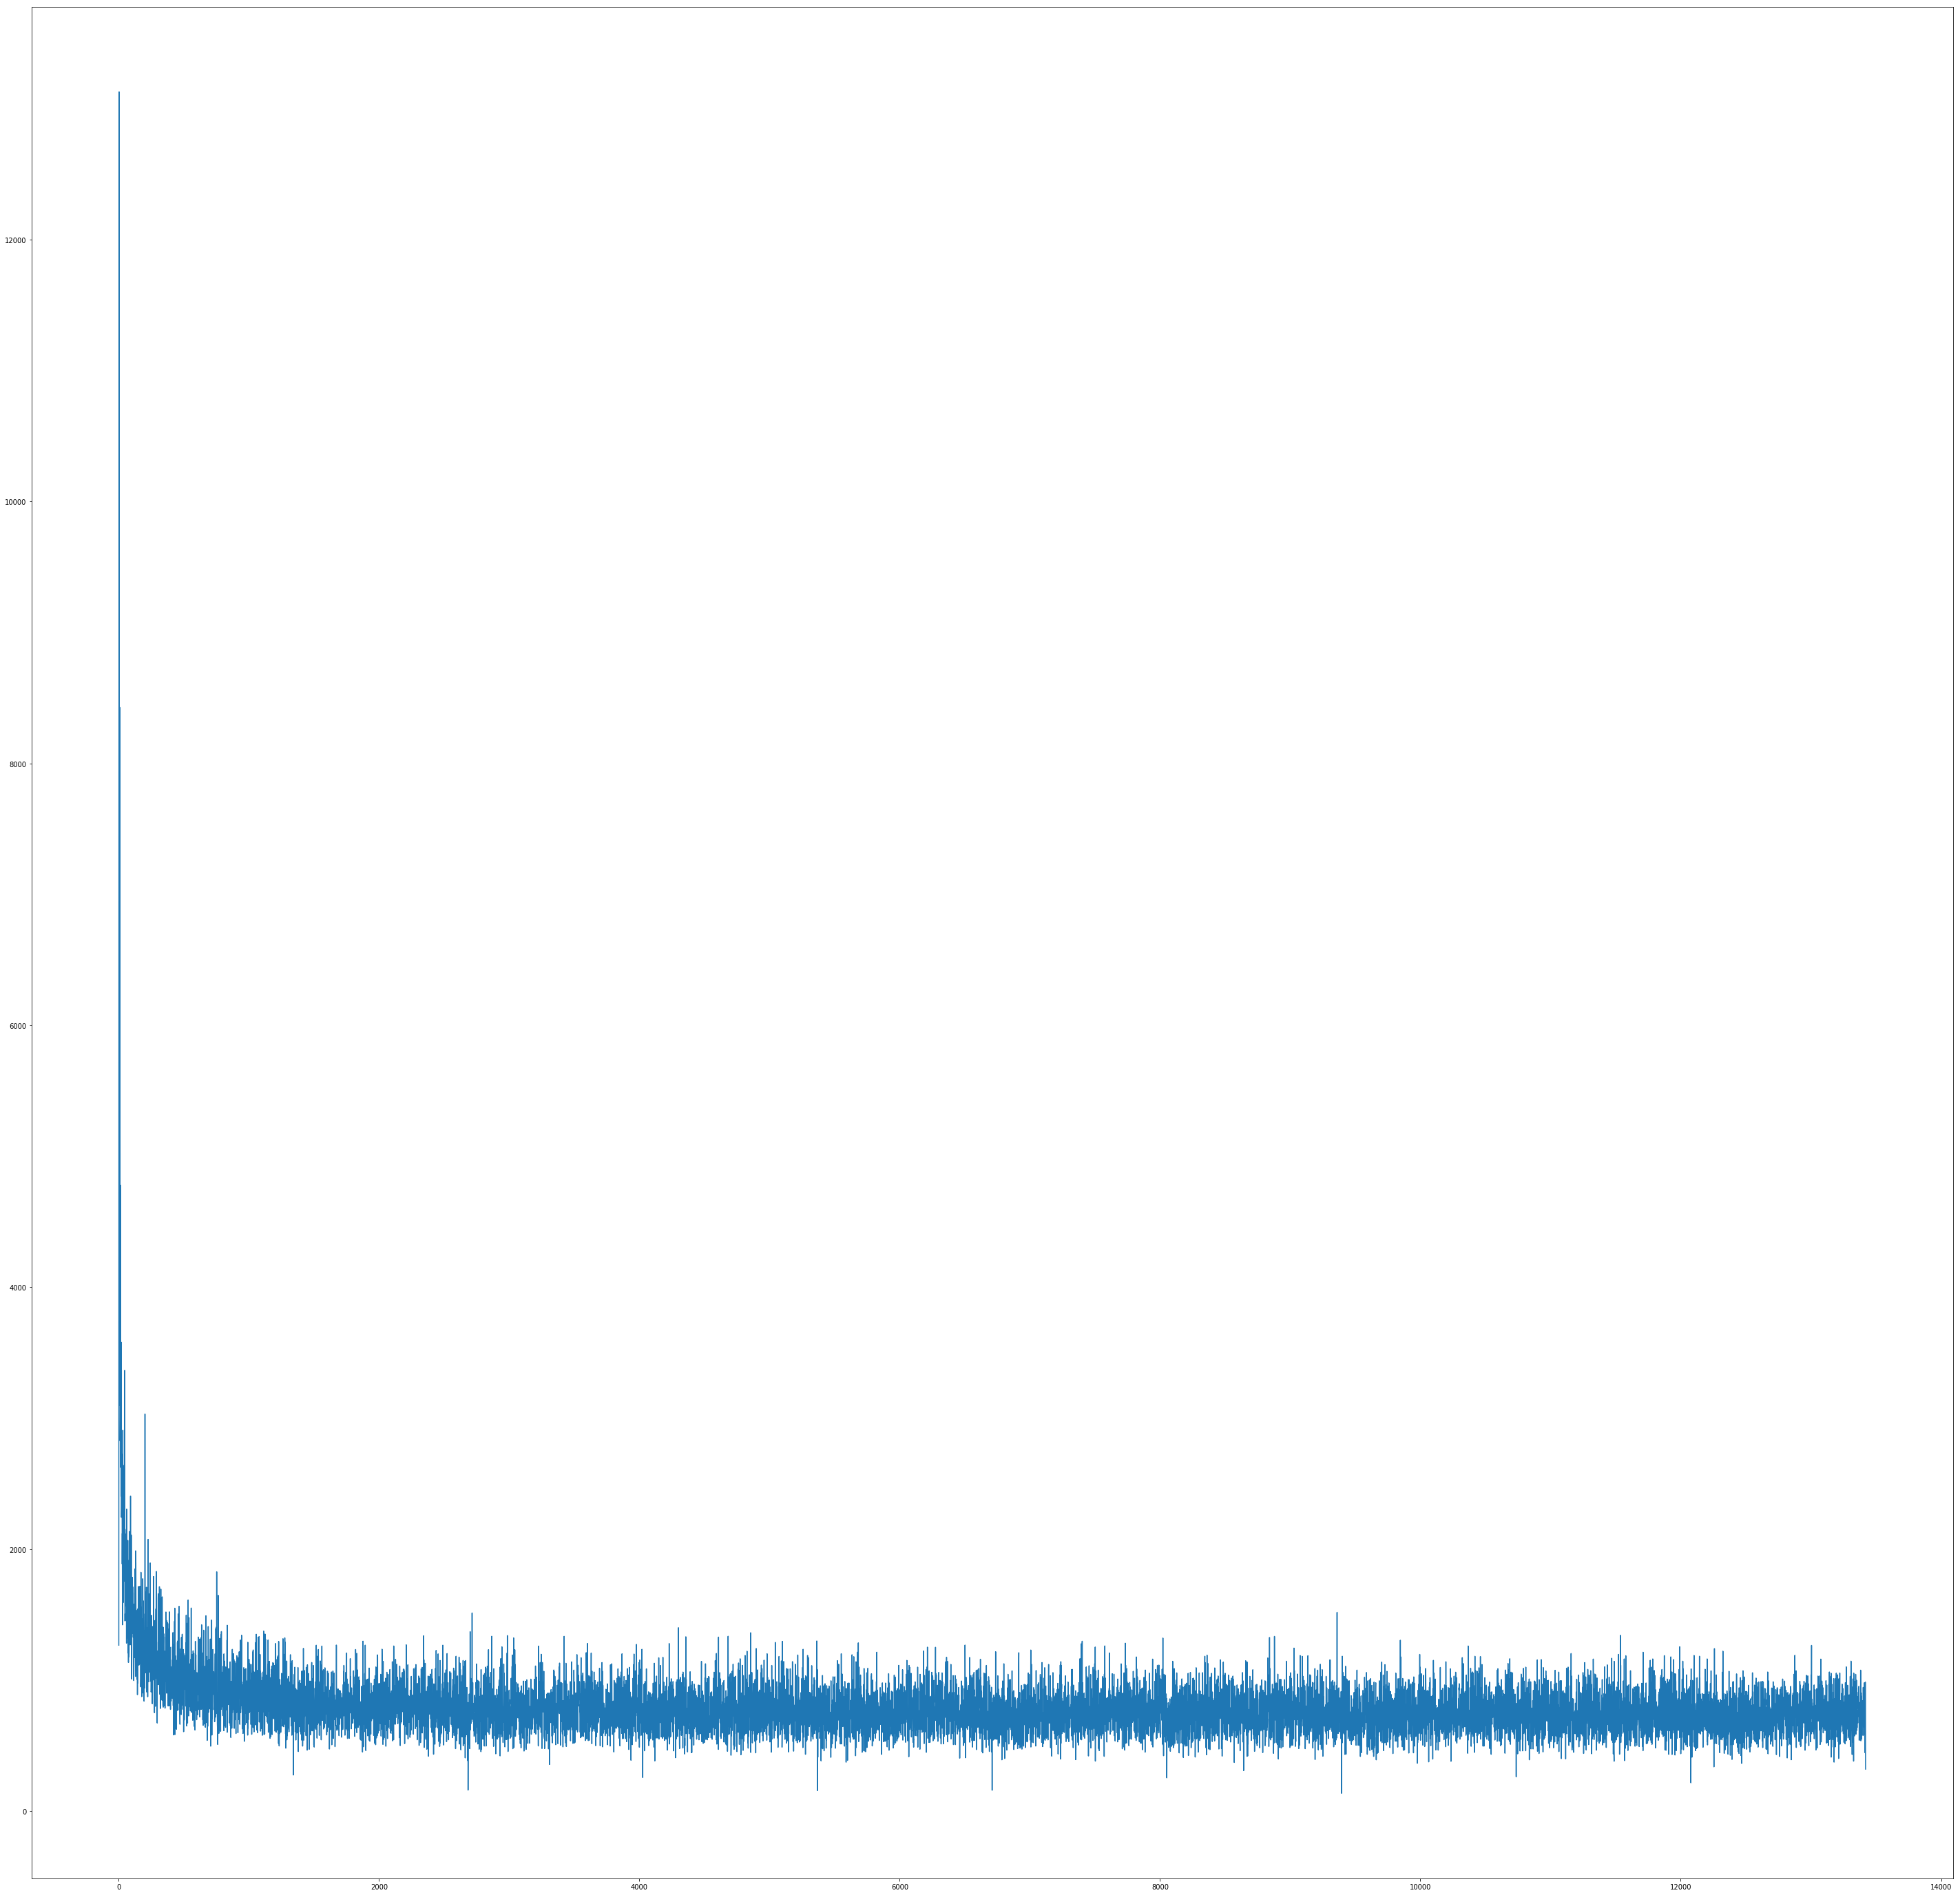

In [22]:
import matplotlib.pyplot as plt
x = np.arange(len(loss_history)) + 1

fig, ax = plt.subplots(figsize=(50,50))     
ax = plt.plot(x, loss_history)

plt.show()

In [12]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn           as sns

from research.models.utils    import *
from research.models.plotting import *

from research.data.gen_session_grouping import gen_sessions

sessions = gen_sessions()

In [13]:
pid2title = dict()
for paper_info in paper_informations:
    pid2title[paper_info['PaperId']] = paper_info['PaperTitle']

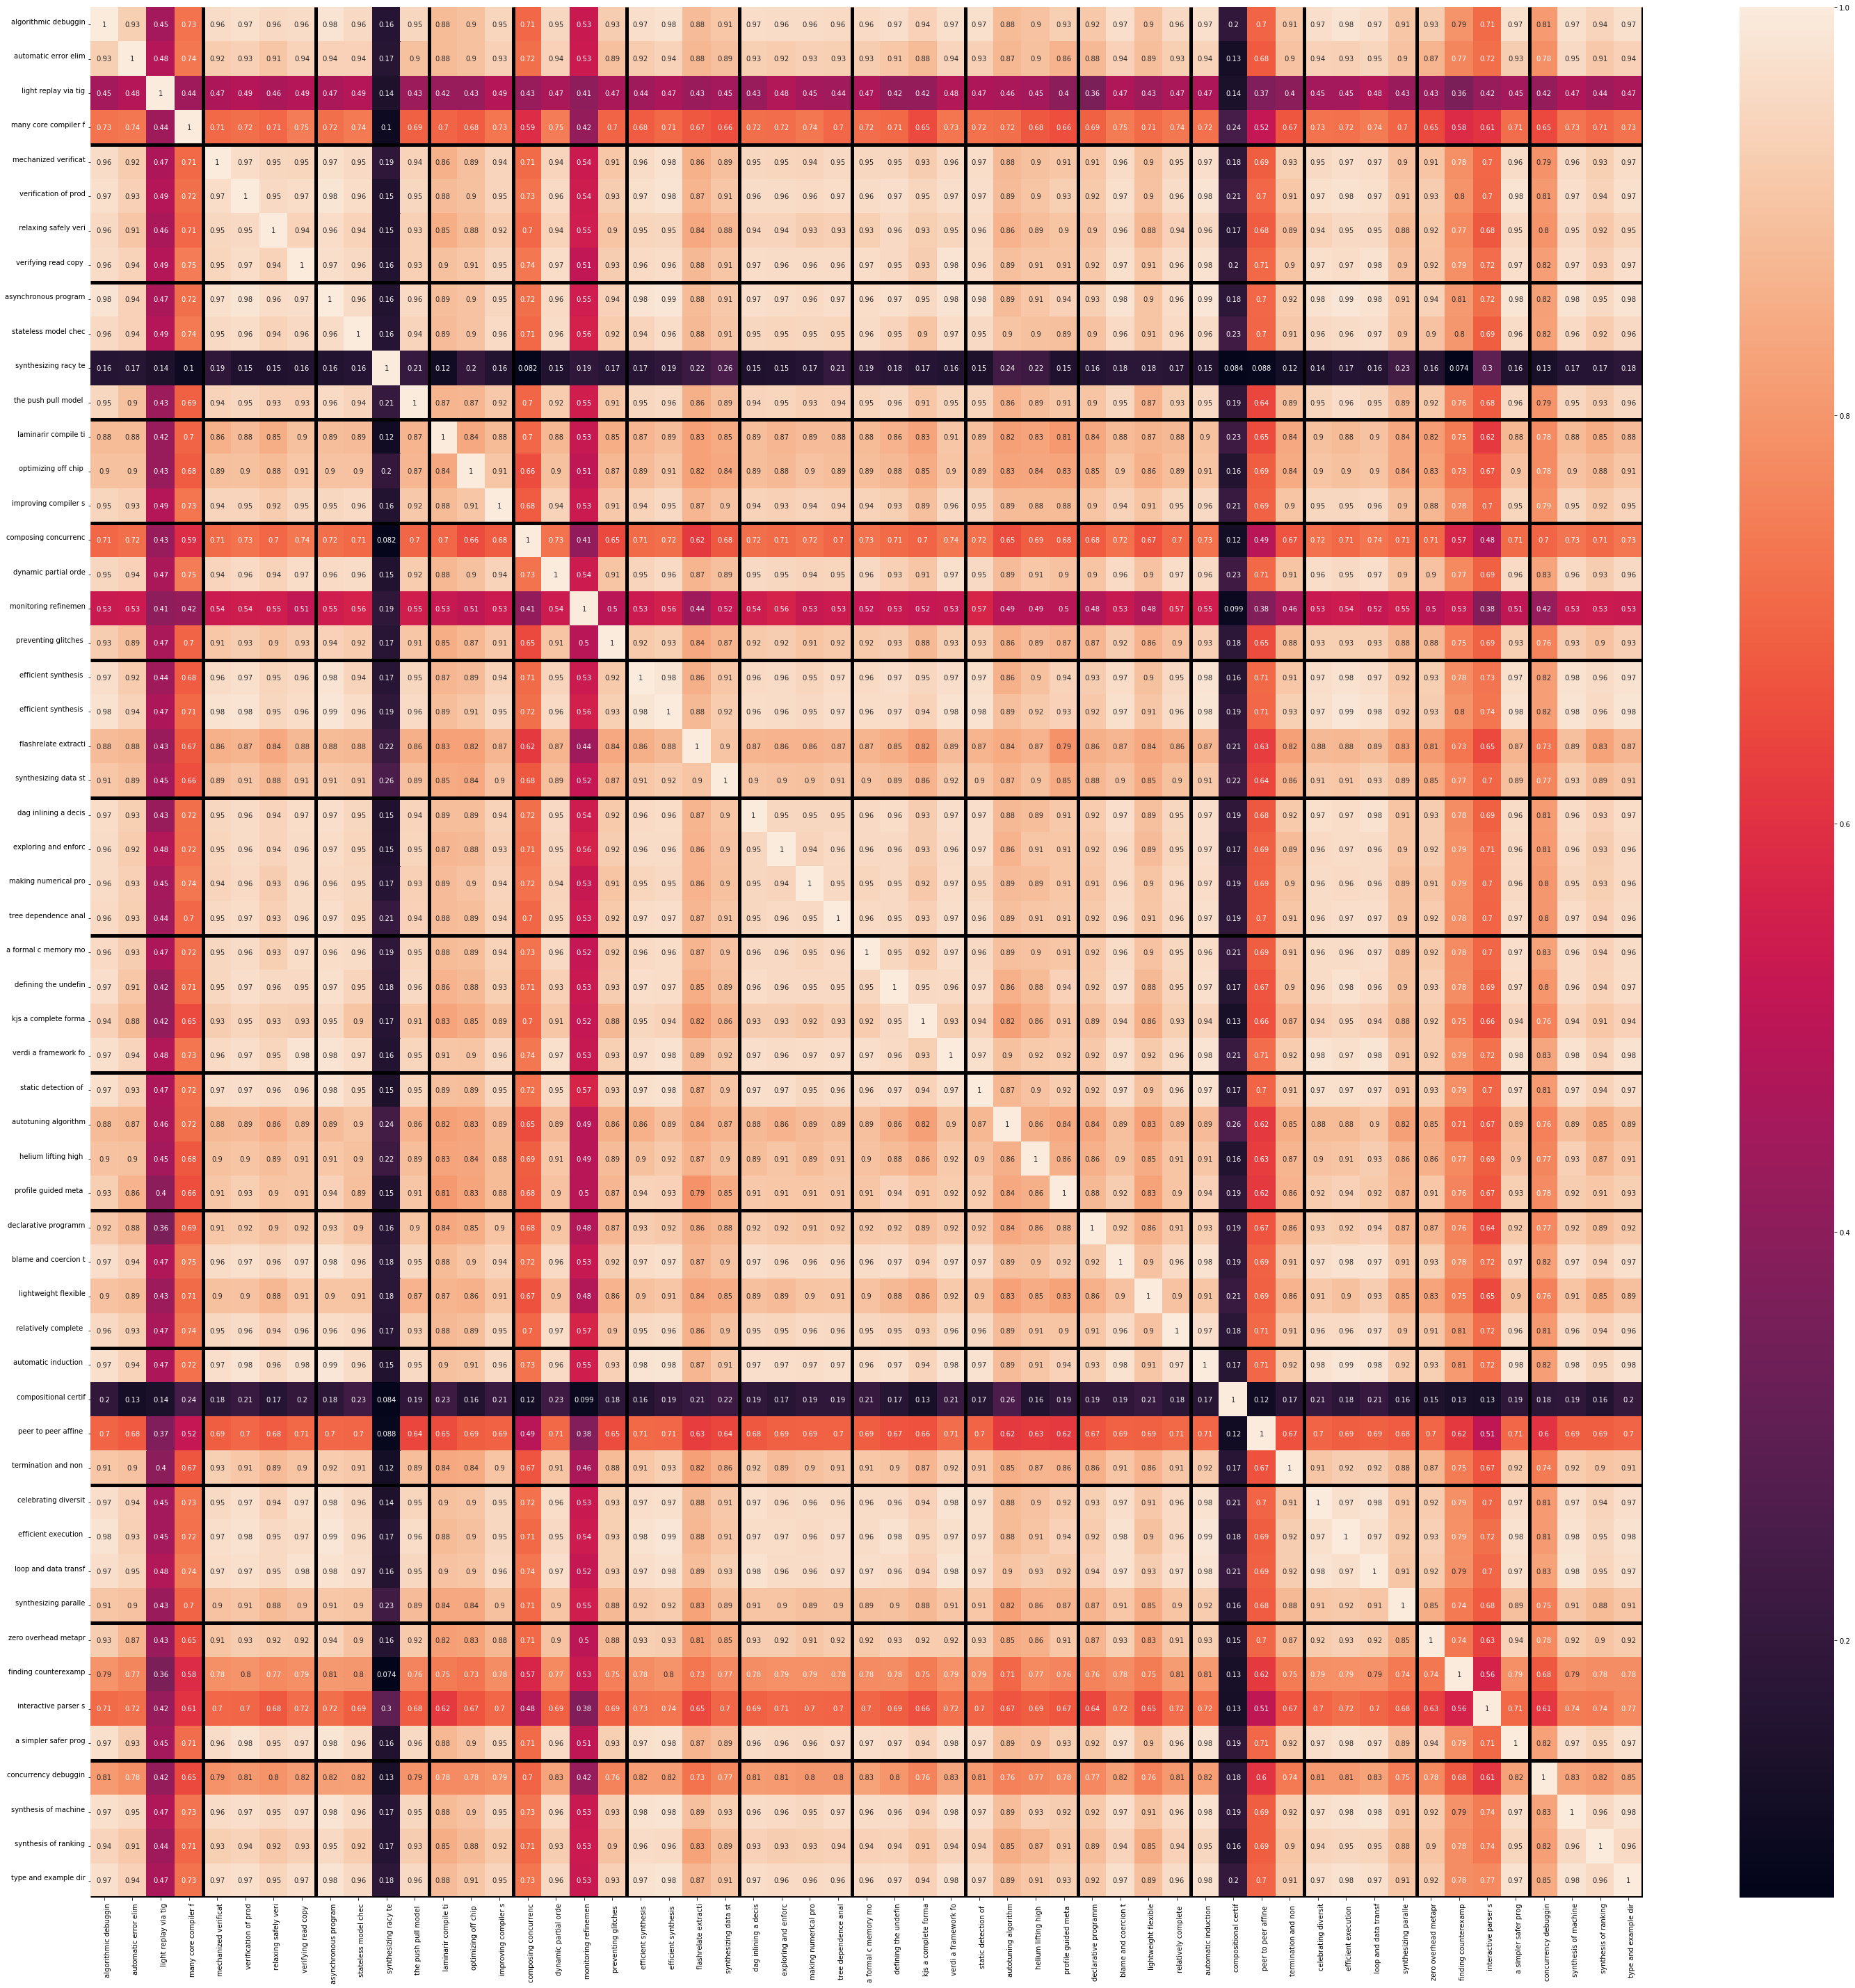

In [14]:
from functools import reduce

session_papers = reduce(lambda x, y: x + y, sessions)

auth_list   = list()
vec_list    = list()

for es_paper_id in session_papers:
    paper_title = pid2title[int(es_paper_id)]
    auth_list.append(paper_title[:20])
    title_indices = list()
    for word in paper_title.split():
        word_idx = preprocess.word2idx[word]
        title_indices.append(word_idx)

    title_vec = torch.mean(model.w_embedding(torch.LongTensor(title_indices)), 0)
    vec_list.append(title_vec.detach().numpy())

fig, ax = plt.subplots(figsize=(50,50))     

sim_matrix = gen_cmp_matrix(vec_list)

ax=cmp_plot(sim_matrix, auth_list, plt)

# Separator lines
separator = np.cumsum([len(s) for s in sessions])
ax.hlines(separator, *ax.get_xlim(), linewidth=5)
ax.vlines(separator, *ax.get_ylim(), linewidth=5)

plt.show()

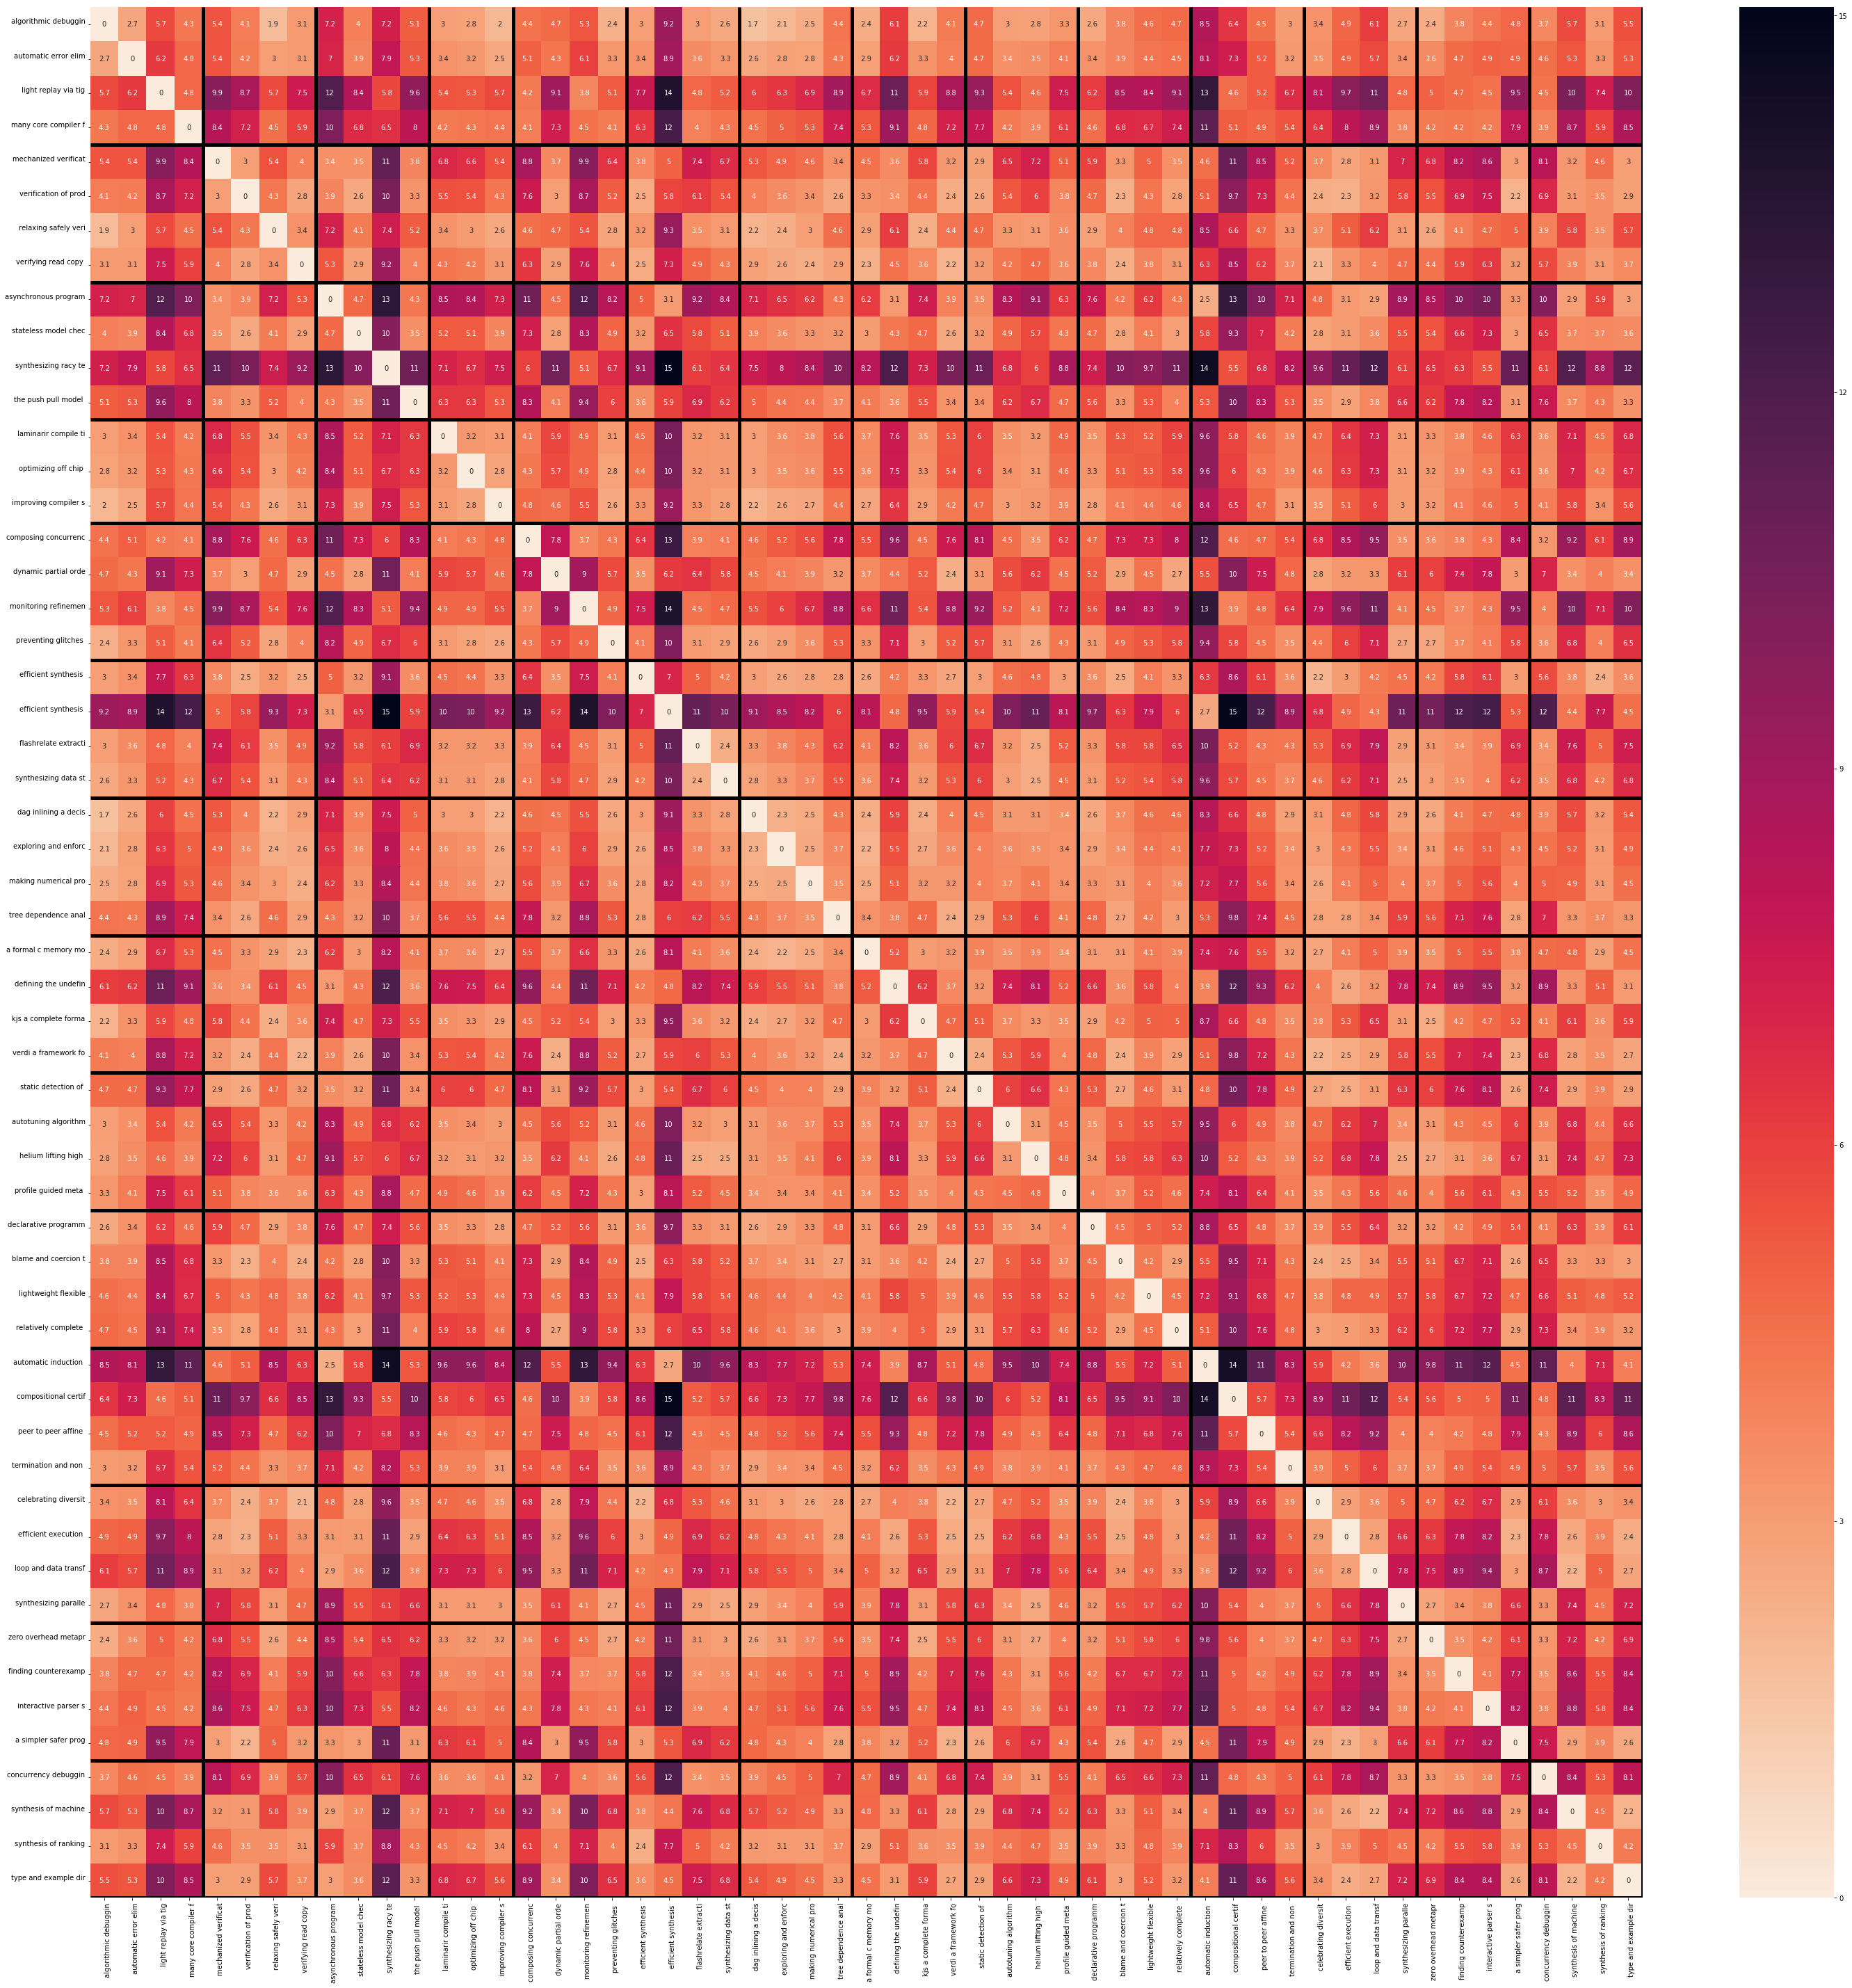

In [15]:
fig, ax = plt.subplots(figsize=(50,50))     

sim_matrix = gen_cmp_matrix(vec_list, calc=lambda x,y: np.linalg.norm(x-y))

ax=cmp_plot(sim_matrix, auth_list, plt, cmap=sns.cm.rocket_r)

# Separator lines
separator = np.cumsum([len(s) for s in sessions])
ax.hlines(separator, *ax.get_xlim(), linewidth=5)
ax.vlines(separator, *ax.get_ylim(), linewidth=5)

plt.show()